In [1]:
%run init_notebook.py

In [2]:
from src.utils import load_pd_df, get_dt_index
from src.processing import pd_join_dfs, pd_groupby, xcorr
from src.statsmodels import *
import scipy

In [3]:
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', ValueWarning)

In [4]:
from src.utils import load_pd_df, save_pd_df, get_dt_index, pd_join_freq, Capturing, cross_corr, pd_df_astype, save_fig, get_stars
from src.processing import pd_groupby, pd_join_dfs, adf_test_summary, hausman, plt_stacked_bar, get_individual_perc_error
from src.pymc_modelling import get_samp

# load data

In [5]:
tlda = load_pd_df("tlda_sum.feather")
tlda = tlda.join(tlda[[i for i in tlda.columns if 'T_sum' in i]].diff().add_suffix("_diff"))

In [6]:
hhp = load_pd_df('hhp_processed.feather')
hhp['ecbtrust'] = hhp['ecbtrust'].astype(float)
hhp['week_recorded'] = hhp.date_recorded.dt.to_period('W').dt.to_timestamp()

pi = load_pd_df("pi.feather")
mir = get_dt_index(load_pd_df('mir.csv'))
bei = load_pd_df('bei.feather')

In [7]:
pi['pi_de_estimate_Y_diff'] = pi.pi_de_estimate_Y.shift(12) - pi.pi_de_estimate_Y
pi['pi_de_surprise_Y_diff'] = pi.pi_de_surprise_Y.shift(12) - pi.pi_de_surprise_Y

In [8]:
pi_shift = pi.dropna().shift(1).copy()[['pi_de_Y', 'pi_de_estimate_Y', 'pi_de_surprise_Y']].add_suffix("_lead1").dropna()

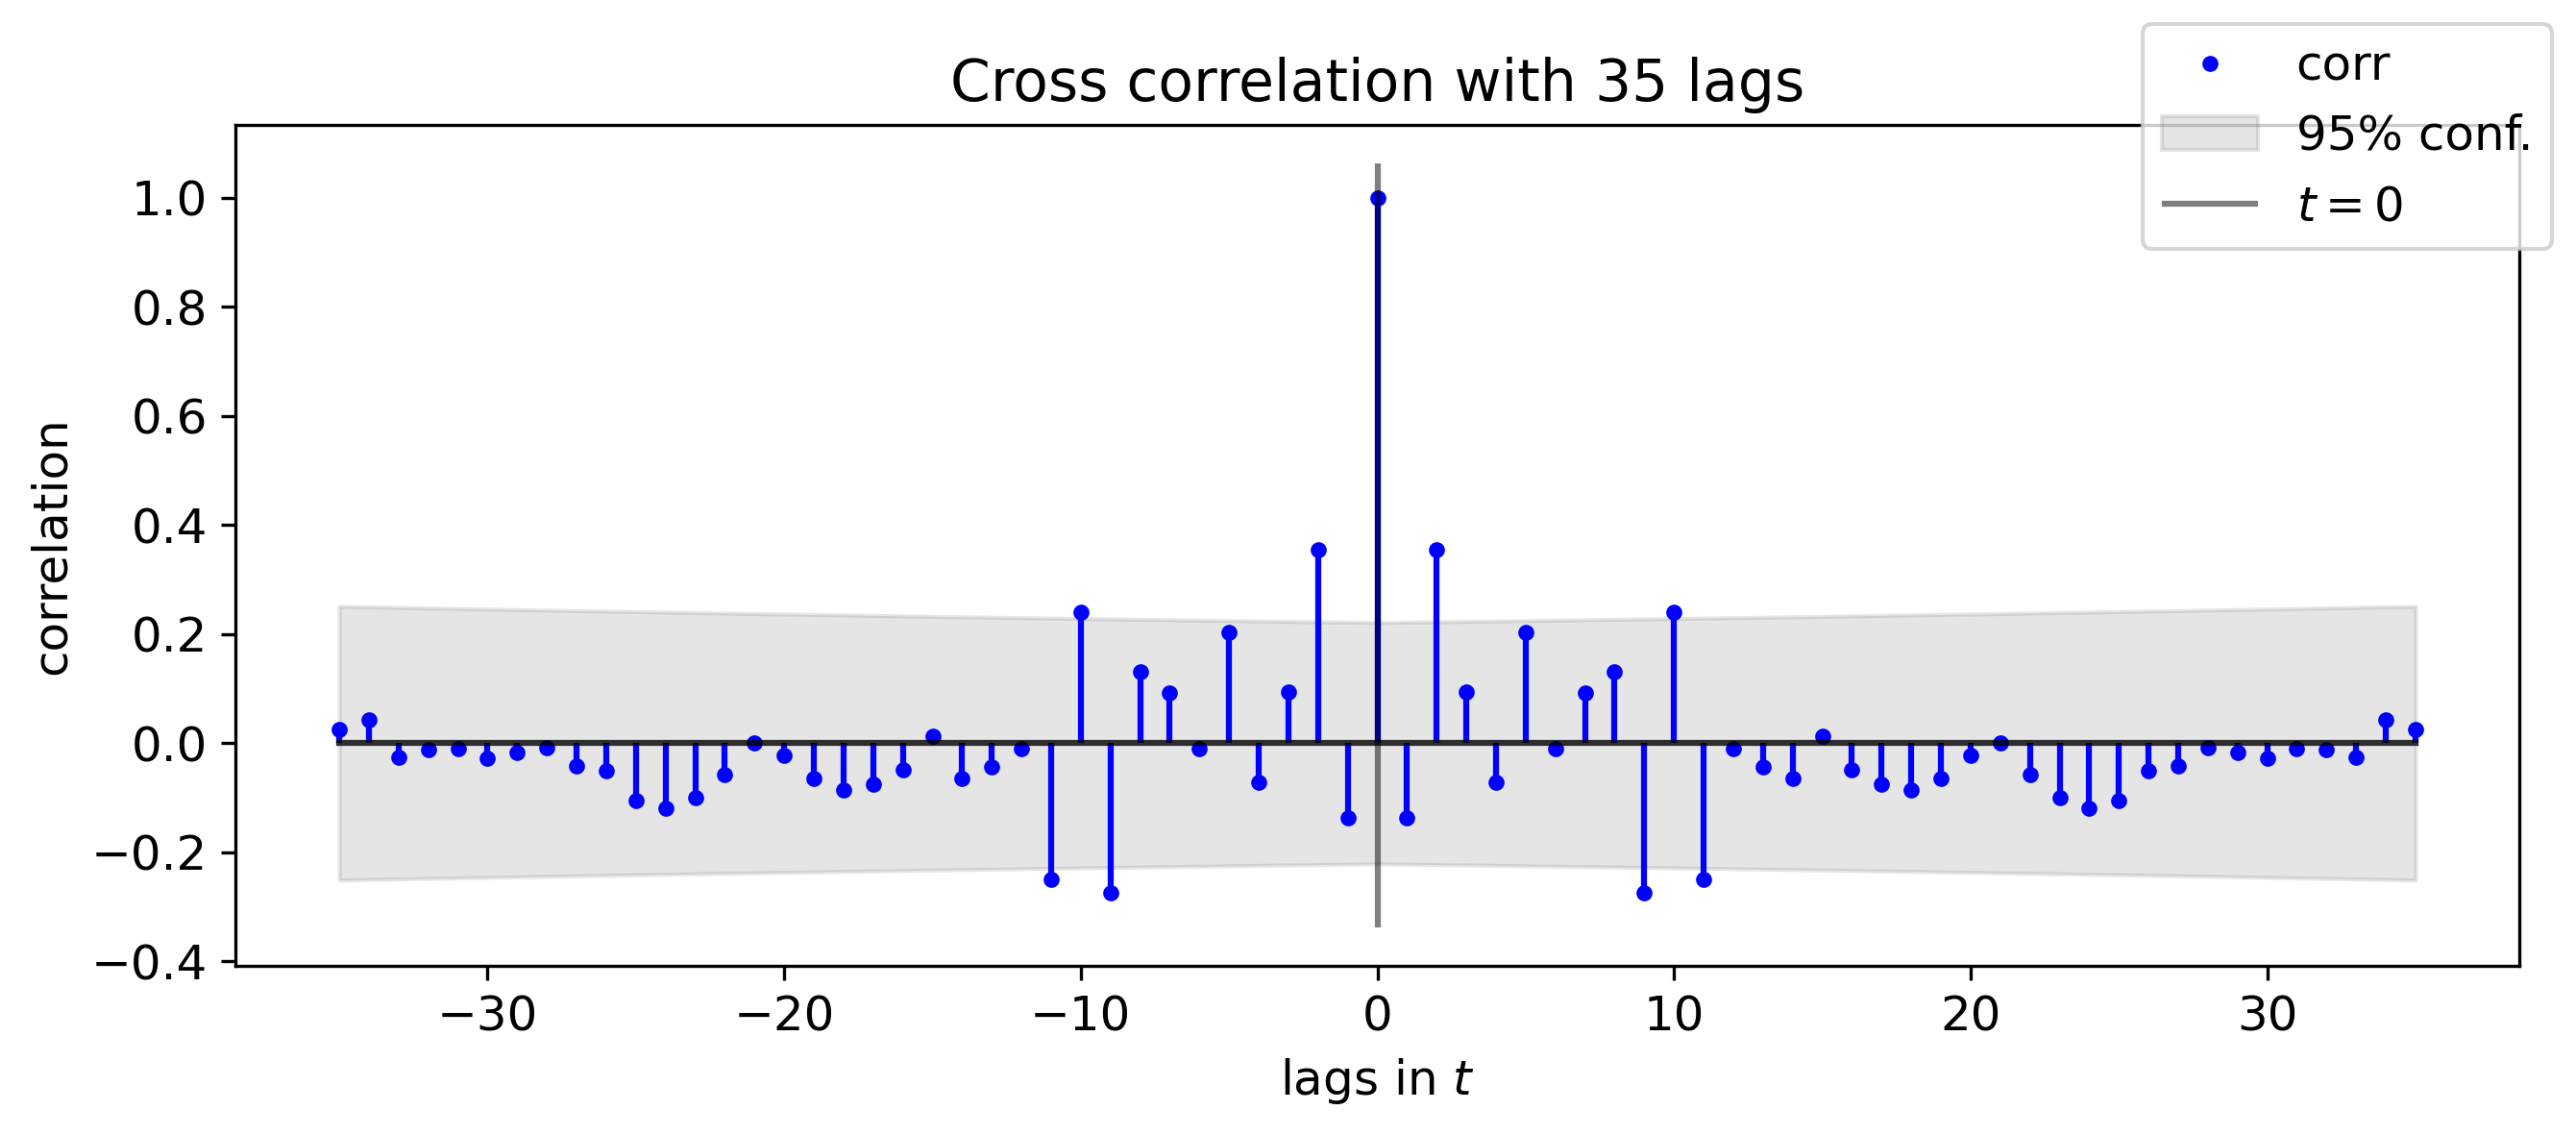

In [9]:
_, _, _, fig = xcorr(pi.pi_de_estimate_Y.diff().dropna(), dpi=300, n_lags=35, figsize=(9,4));
fig, ax = fig
save_fig(fig, 'emp_pi_structural_acorr.png')

## macro analysis

In [10]:
# join hhp data at recorded date
df = hhp.set_index('date_recorded')[
    [
        'pi_perc', 'id', 'hhinc', 'hhinc_delta', 'hhinc_midpoint', 'delta_pe', 'delta_pe_WY', 'delta_pe_MY', 'pi_perc_MY', 
        'pi_perc_WY', 'percprob_war', 'percprob_covid', 'date_forecast',  'debt', 'wealth_bank', 'eduschool', 'hhsize', 'ecbtrust',
        'pi_perc95_MY', 'pi_perc05_MY', 'pi_perc05_WY', 'pi_perc95_WY', 'pi_exp', 'eduwork_txt', 'pi_exp_MY', 'i_exp_MY', 'i_exp_WY',
        'pi_exp_WY', 'riskaversion', 'eduwork', 'savings_planned',
    ]
].drop_duplicates().copy()
df = df.reset_index()

In [11]:
# set index and time frequncies
df['week_recorded'] = df.date_recorded.dt.to_period('W').dt.to_timestamp()
df['week_forecast'] = df.date_forecast.dt.to_period('W').dt.to_timestamp()
df['month_recorded'] = df.date_recorded.dt.to_period('M').dt.to_timestamp()

df = df.reset_index(drop=True)

In [12]:
# join hhp data on forecast date
df = pd_join_freq(
    df.set_index('date_forecast'),
    hhp.set_index('date_forecast')[
        ['pi_exp_MY', 'i_exp_MY', 'pi_exp975_MY', 'pi_exp975_WY', 'pi_exp025_MY', 'pi_exp025_WY', 'pi_exp_WY', 'delta_pe_MY', 
         'delta_pe_WY',]
    ].drop_duplicates().add_suffix("_F"),
    'W',
)
df = df.reset_index(drop=True)

In [13]:
# join pi shift
df = pd_join_freq(df.set_index('date_recorded'), pi_shift, 'M')

In [14]:
# get uncertainty 
df['pi_exp_uncertainty_WY_F'] = df['pi_exp975_WY_F'] - df['pi_exp025_WY_F']
df['pi_perc_uncertainty_WY'] = df['pi_perc95_WY'] - df['pi_perc05_WY']

df['pi_exp_uncertainty_MY_F'] = df['pi_exp975_MY_F'] - df['pi_exp025_MY_F']
df['pi_perc_uncertainty_MY'] = df['pi_perc95_MY'] - df['pi_perc05_MY']

In [15]:
df.groupby(['id', 'week_recorded']).pi_perc.last().unstack().count(axis=1).describe()

count    52390.000000
mean         1.953903
std          1.902396
min          0.000000
25%          1.000000
50%          1.000000
75%          3.000000
max         10.000000
dtype: float64

In [16]:
# join other dfs
df = df.set_index('date_recorded')

_ = tlda[[i for i in tlda.columns if 'T_sum' in i]].copy()
_.index.name = 'date'
df = pd_join_freq(df, _, "W", True)

df = pd_join_freq(df, mir[['ecb_rate']], "M", True)
df = pd_join_freq(df, pi[
    ['pi_de_Y', 'pi_de_surprise_Y', 'pi_de_surprise', 'pi_de_estimate', 'pi_de_estimate_Y', 'pi_de_Y_diff', 
     'pi_de_estimate_Y_diff', 'pi_de_surprise_Y_diff']
], 'M', True)
df = df.join(bei.bei)

In [17]:
df = df.reset_index(drop=True)

In [18]:
# get residuals
df = get_individual_perc_error(df, 'pi_perc_MY', pi[['pi_de_Y']], agg_col_suffix='all', count_thresh=1)
df = get_individual_perc_error(df, 'pi_perc_MY', pi[['pi_de_Y']], count_thresh=6)

df = get_individual_perc_error(df, 'pi_perc_MY', pi_shift[['pi_de_Y_lead1']], agg_col_suffix='all_S', count_thresh=1)
df = get_individual_perc_error(df, 'pi_perc_MY', pi_shift[['pi_de_Y_lead1']], agg_col_suffix="S", count_thresh=6)

# df = get_individual_perc_error(df, 'pi_perc_MY', pi_shift[['pi_de_Y_SM']], agg_col_suffix='all_SM', count_thresh=1)
# df = get_individual_perc_error(df, 'pi_perc_MY', pi_shift[['pi_de_Y_SM']], agg_col_suffix="SM", count_thresh=6)

df = get_individual_perc_error(df, 'delta_pe_MY', pi[['pi_de_Y_diff']], ind_cols=['date_forecast', 'id'], count_thresh=5)
df = get_individual_perc_error(df, 'pi_exp_MY', pi[['pi_de_Y']], ind_cols=['date_forecast', 'id'], count_thresh=5)

In [19]:
# get residuals monthly
for col in [
    ('recorded', 'delta_pe_MY_error_act'), ('recorded', 'pi_perc_MY_all_error_act'),
    ('recorded', 'pi_perc_MY_all_S_error_act'), 
    # ('recorded', 'pi_perc_MY_all_SM_error_act')
]:

    sub = df[[f'date_{col[0]}', f'week_{col[0]}', 'id', col[1]]].drop_duplicates().dropna().groupby(f'week_{col[0]}')[col[1]].median().copy()
    sub /= 100
    df = pd_join_freq(df.set_index('date_recorded'), pd.DataFrame(sub.rename(f'{col[1]}_WY')), 'W', keep_left_index=True).copy()
    df = pd_join_freq(df, 
                     pd_groupby(pd.DataFrame(sub.rename(f'{col[1]}_MY')), [f'{col[1]}_MY'], 'M', 'last'),
                     'M', keep_left_index=True)
df = df.reset_index(drop=True)

In [20]:
# check

In [26]:
df.groupby(['id', 'week_recorded']).pi_perc.last().unstack().count(axis=1).describe()

count    45067.000000
mean         2.070029
std          1.841335
min          0.000000
25%          1.000000
50%          1.000000
75%          3.000000
max         10.000000
dtype: float64

In [29]:
save_pd_df(df, "df_analysis.feather", DATA_DIR)

## micro analysis

In [30]:
# join pi to hhp on a monthly level
df_micro = hhp.set_index('date_recorded')[
    [
        'date_forecast', 'pi_perc', 'pi_perc_WY', 'id', 'hhinc_midpoint', 'debt', 'is_homeown', 'wealth_bank', 'is_unempl',
        'pinc_midpoint', 'eduwork', 'profession', 'delta_pe', 'pi_exp', 'hhinc', 'ecbtrust', 'savings_planned', 'hhsize',
    ]
].copy().reset_index()
df_micro = pd_join_freq(
    df_micro.set_index('date_recorded'),
    pi[['pi_de_Y',  'pi_de_surprise_Y', 'pi_de_estimate_Y',]], 'M', keep_left_index=True
).reset_index(drop=True)

df_micro = pd_join_freq(
    df_micro.set_index('date_forecast'),
    pi[['pi_de_Y_diff']].rename(columns={'pi_de_Y_diff': 'pi_de_Y_diff_F'}), 'M', keep_left_index=True
).reset_index(drop=True)

df_micro = pd_join_freq(
    df_micro.set_index('date_recorded'),
    pi_shift, 'M', keep_left_index=True
).reset_index(drop=True)

# joint news data
_ = tlda[[i for i in tlda.columns if 'T_sum' in i]]
_.index.name = 'date'
df_micro = pd_join_freq(
    df_micro.set_index('date_recorded'), 
    _, "W", keep_left_index=True, how='left').sort_index().reset_index(drop=True)

df_micro['week_recorded'] = df_micro.date_recorded.dt.to_period('W').dt.to_timestamp()
df_micro['month_recorded'] = df_micro.date_recorded.dt.to_period('M').dt.to_timestamp()

df_micro['pi_perc_error'] = df_micro['pi_perc'] - df_micro.pi_de_Y
df_micro['delta_pe_error'] = df_micro['delta_pe'] - df_micro.pi_de_Y_diff_F

# _ = df[['pi_de_Y', 'pi_perc_WY']].apply(lambda x: x.iloc[1] - x.iloc[0], axis=1).copy().rename('pi_perc_error')
# df['pi_perc_error'] = _

In [31]:
save_pd_df(df_micro, 'df_analysis_micro.feather', DATA_DIR)

# desrcb stats

In [64]:
sub = df.set_index(['id', 'week_recorded'])[
    ['pi_perc', 'delta_pe', 'pi_exp', 'hhinc_midpoint', 'riskaversion', 'pi_perc_MY_error_act', 'delta_pe_MY_error_act',]
].drop_duplicates().sort_index().astype(float) * 100
sub = sub.describe().copy()

sub.loc['N individuals'] = np.zeros(sub.shape[1])
sub.loc['N weeks'] = np.zeros(sub.shape[1])
sub.loc['dtype'] = np.zeros(sub.shape[1]).astype(str)

sub = sub.rename(index={'count': 'N'})

for col in sub:
    _ = df[['id', 'week_recorded'] + [col]].drop_duplicates().dropna().copy()
    sub.loc['N weeks', col] = len(_.week_recorded.unique())
    sub.loc['N individuals', col] = len(_.id.unique())
        
sub = sub.astype(float).round(4)
_ = df[
        ['week_recorded', 'pi_de_surprise_Y', 'pi_de_estimate_Y',]
    ].drop_duplicates().iloc[:,1:] * 100
sub = sub.join(
    _.describe().rename(index={'count': 'N month'}).round(4), 
    how='outer', 
) #sort=True)

_ = df.set_index('date_recorded')[['T_sum_ind_op']].drop_duplicates() * 100
sub = sub.join(
    _.describe().rename(index={'count': 'N days'}).round(4), 
    how='outer', 
) #sort=True)

sub = sub.rename(index={'25%': 'Q1', "75%": "Q2"}).drop("50%")
# for col in sub:
#     sub.loc['dtype', col] = str(DICT_PARSE_COLS[col])

sub = sub.fillna("").sort_index(ascending=True).loc[
    ['mean', 'std', 'min', 'max', 'Q1', 'Q2', 'N', 'N individuals', 'N weeks', 'N month', 'N days', 'dtype']
]
sub = sub.round(3)
save_pd_df(sub, "data_describtives.csv", GRAPHS_DIR)

In [65]:
sub = df[
    ['month_recorded', 'pi_de_surprise_Y', 'pi_de_estimate_Y', 'delta_pe_MY', 'pi_perc_MY', 'T_sum_ind_op', 
     'pi_perc_MY_error_act', 'delta_pe_MY_error_act']
].drop_duplicates().dropna().iloc[:,1:].corr().round(3).copy()
save_pd_df(sub, "data_corr_matrix.csv", GRAPHS_DIR)

## plot time series inflation

In [261]:
sub = pd_groupby(df.set_index('date_recorded'),
           ['pi_de_Y', 'pi_de_surprise_Y', 'pi_de_estimate_Y', 'pi_perc_MY', 'pi_exp_MY', 'delta_pe',
            'pi_perc95_MY', 'pi_perc05_MY'],
           "M", 'last').dropna()
sub = pd_join_freq(sub,
                   pd_groupby(df.set_index('date_recorded'),
                              ['pi_perc_MY_error_act', 'pi_perc_MY_S_error_act', 'delta_pe_MY_error_act'], 'M', 'mean'),
                   'M')
sub2 = pd_groupby(df.set_index('date_forecast'), 
                  ['pi_exp975_MY_F', 'pi_exp025_MY_F', 'pi_exp_MY_F', 'delta_pe_MY_F', 
                   'pi_exp_MY', 'delta_pe_MY_error_act'], 
                  'M', 'last').dropna()
sub2 = sub2.join(
    pi[['pi_de_Y_diff', 'pi_de_Y', 'pi_de_estimate_Y', 'pi_de_surprise_Y', 'pi_de_estimate_Y_diff', 'pi_de_surprise_Y_diff']]
)

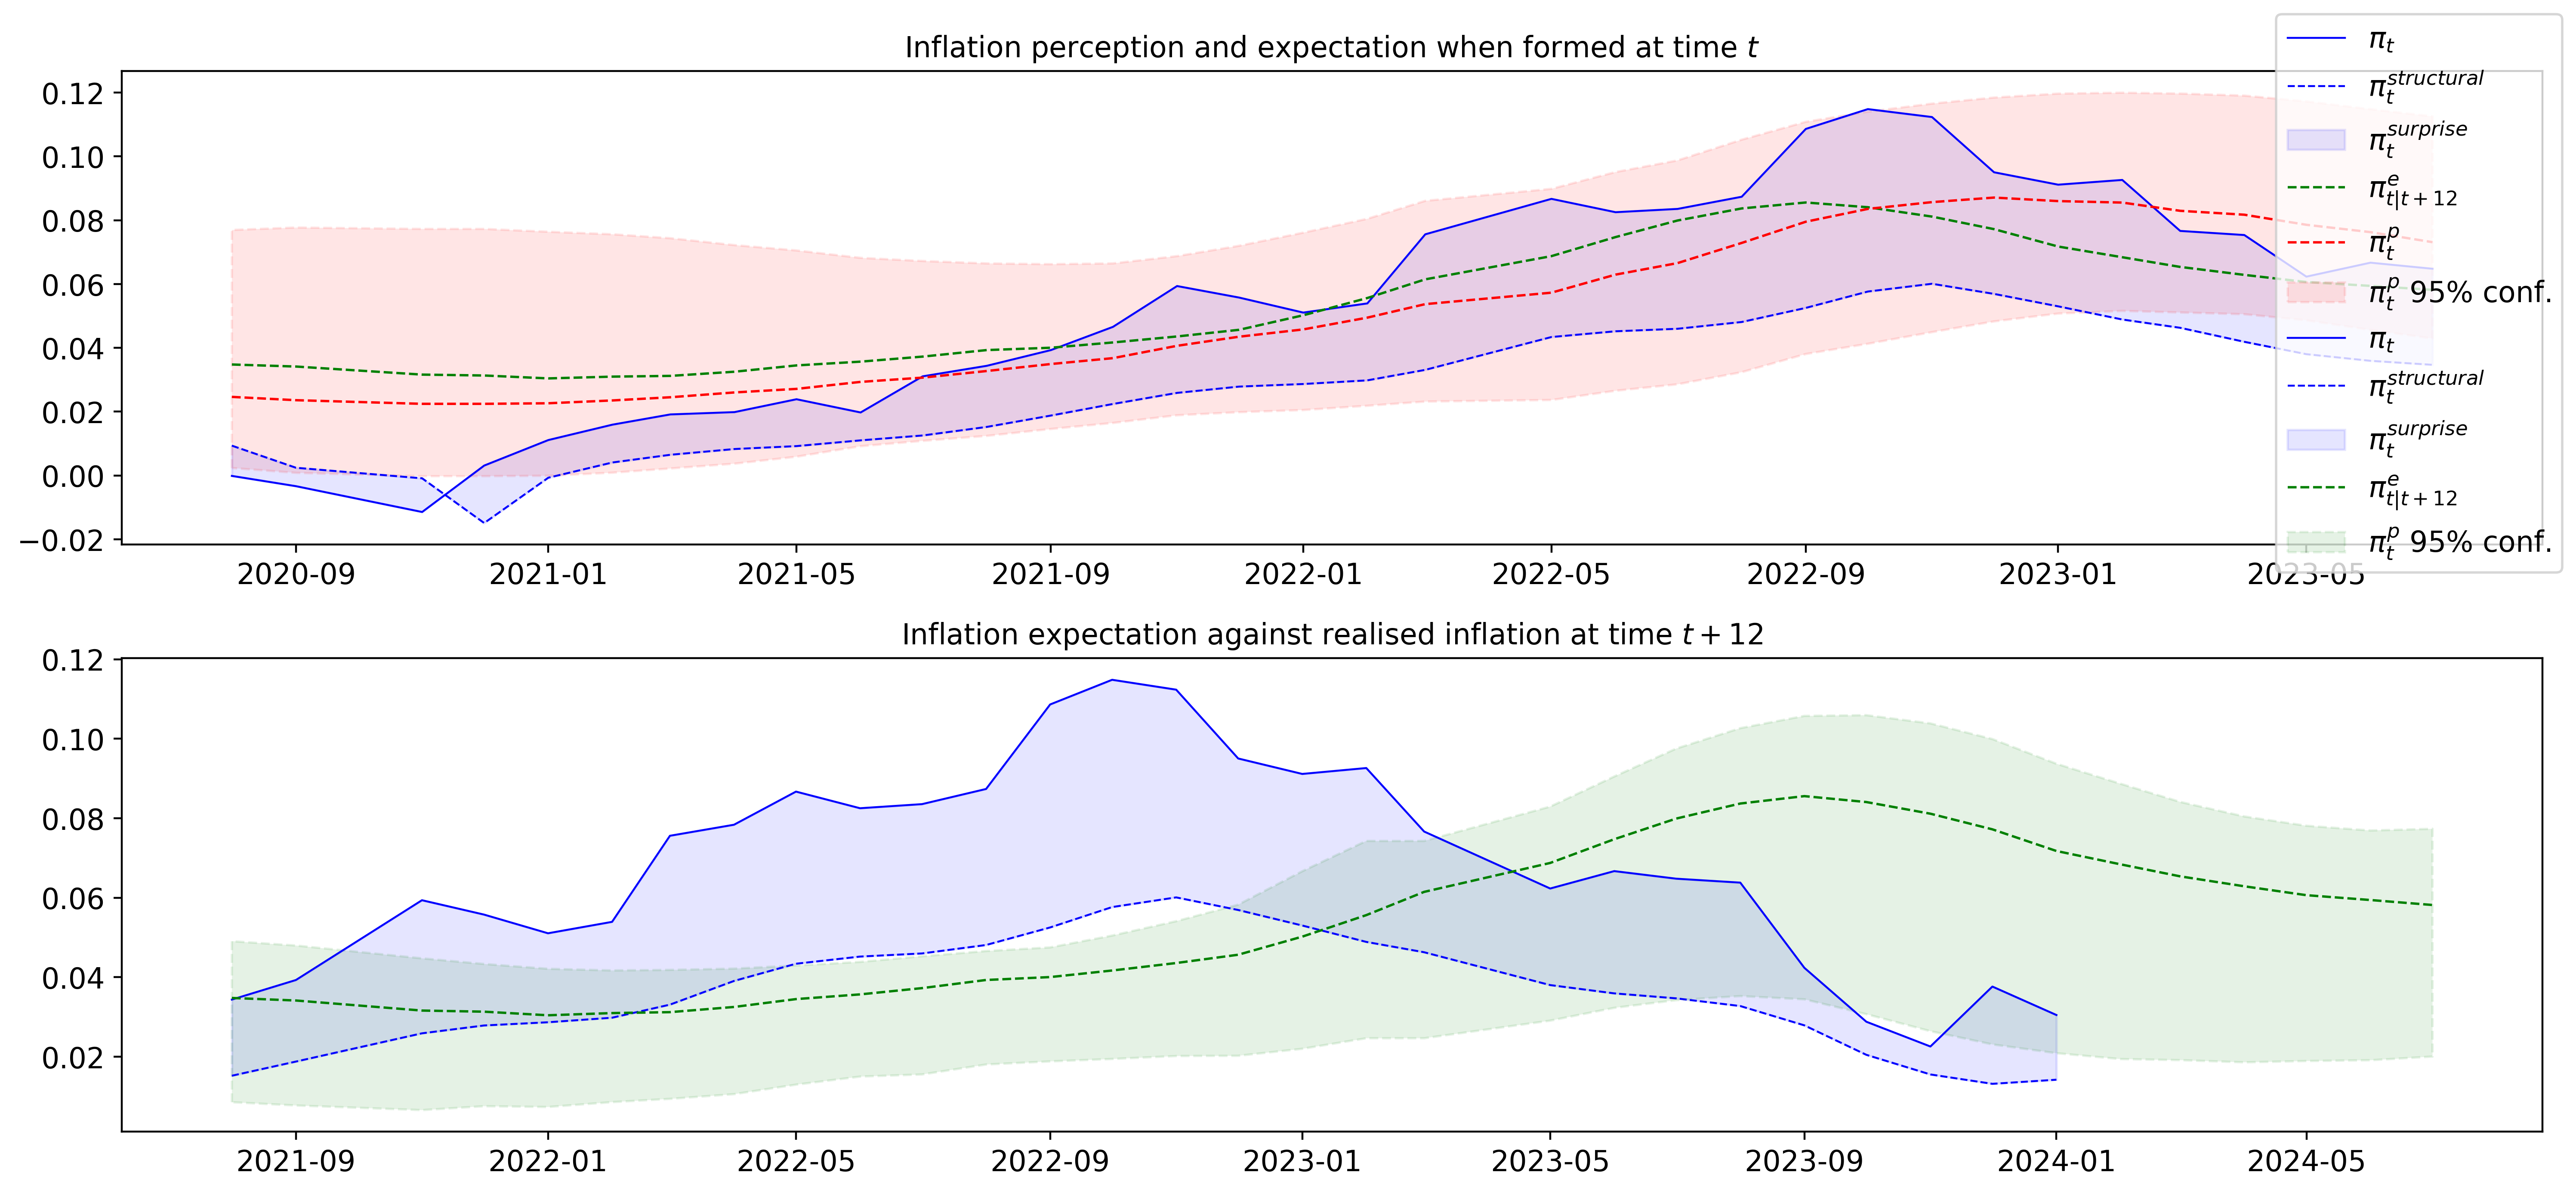

In [262]:
fig, ax = plt.subplots(2,1, figsize=(15,7), dpi=400)

ax[0].plot(sub['pi_de_Y'], color='blue', lw=.8, label='$\pi_t$')
ax[0].plot(sub['pi_de_estimate_Y'], color='blue', linestyle='dashed', lw=.8, label='$\pi^{structural}_t$')
ax[0].fill_between(sub.index, sub['pi_de_estimate_Y'], sub['pi_de_Y'], color='blue', alpha=.1, label="$\pi^{surprise}_t$",)

ax[0].plot(sub['pi_exp_MY'], color='green', linestyle='dashed', lw=1, label=r'$\pi^e_{t|t+12}$')
ax[0].plot(sub['pi_perc_MY'], linestyle='dashed', color='red', lw=1, label=r'$\pi^p_{t}$')
ax[0].fill_between(sub.index, sub['pi_perc95_MY'], sub['pi_perc05_MY'], color='red', linestyle='dashed',
                alpha=.1, label='$\pi^p_{t}$ 95% conf.')
ax[0].set_title('Inflation perception and expectation when formed at time $t$', size=12)

ax[1].plot(sub2['pi_de_Y'], color='blue', lw=.8, label='$\pi_t$')
ax[1].plot(sub2['pi_de_estimate_Y'], color='blue', linestyle='dashed', lw=.8, label='$\pi^{structural}_t$')
ax[1].fill_between(sub2.index, sub2['pi_de_estimate_Y'], sub2['pi_de_Y'], color='blue', alpha=.1, label="$\pi^{surprise}_t$",)
ax[1].plot(sub2['pi_exp_MY_F'], color='green', linestyle='dashed', lw=1, label=r'$\pi^e_{t|t+12}$')
ax[1].fill_between(sub2.index, sub2['pi_exp975_MY_F'], sub2['pi_exp025_MY_F'], color='green', linestyle='dashed',
                alpha=.1, label='$\pi^p_{t}$ 95% conf.')

ax[1].set_title("Inflation expectation against realised inflation at time $t+12$", size=12)

fig.legend()

fig.tight_layout()
save_fig(fig, 'plot_inflation1.png')

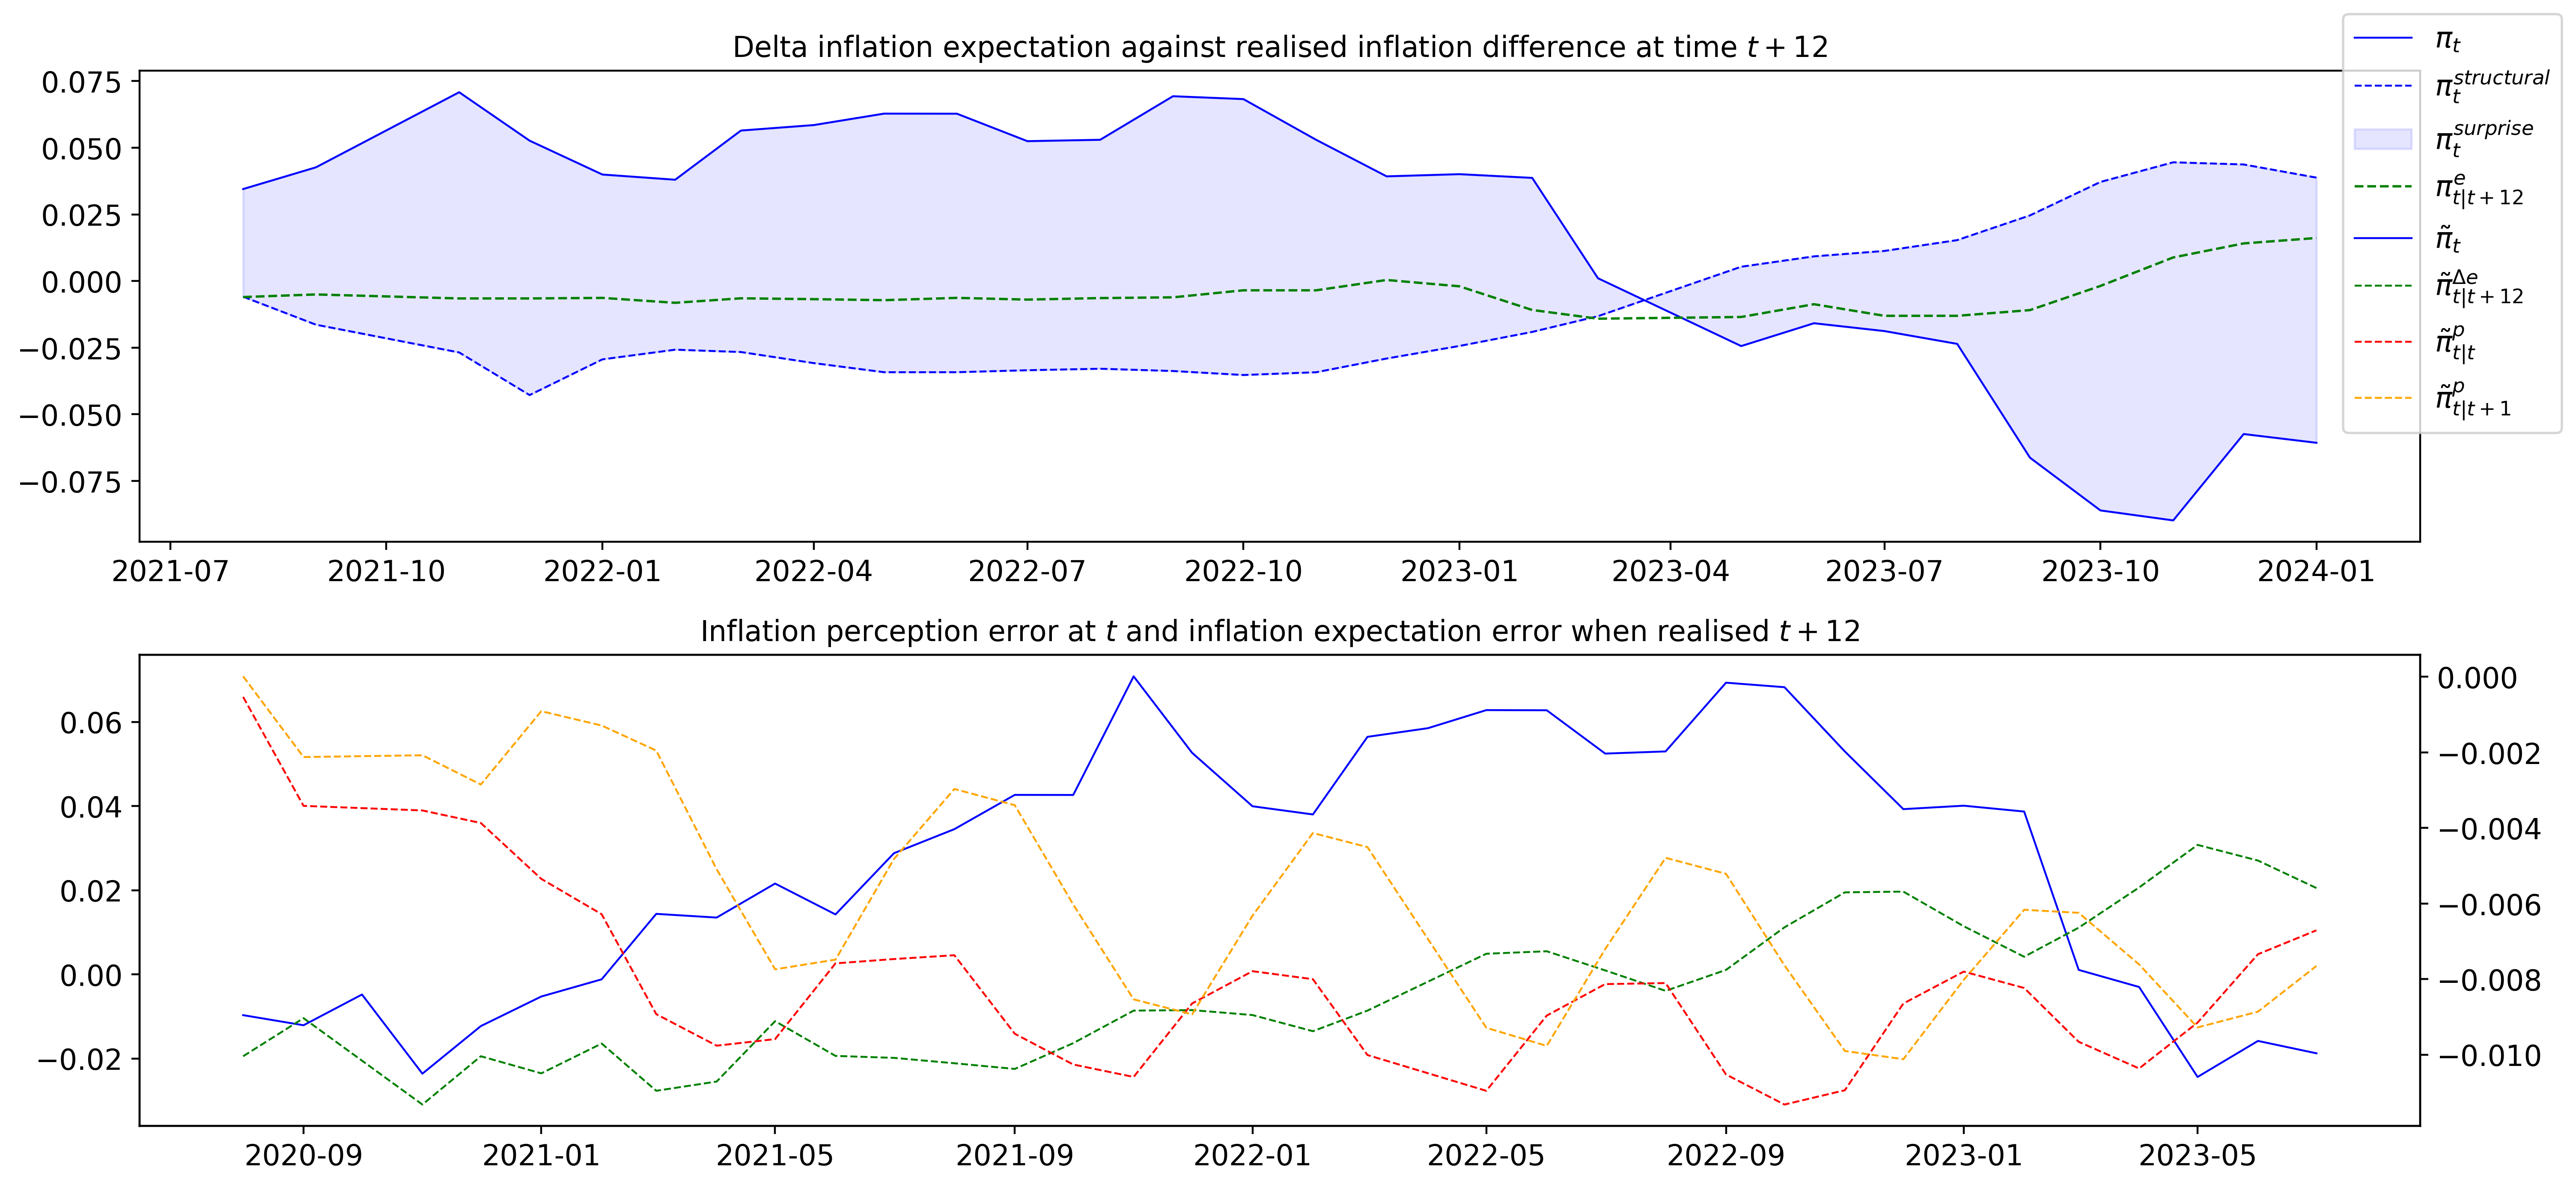

In [264]:
fig, ax = plt.subplots(2,1, figsize=(15,7), dpi=400)

ax[0].plot(sub2['pi_de_Y_diff'], color='blue', lw=.8, label='$\pi_t$')
ax[0].plot(sub2['pi_de_estimate_Y_diff'], color='blue', linestyle='dashed', lw=.8, label='$\pi^{structural}_t$')
ax[0].fill_between(sub2.index, sub2['pi_de_estimate_Y_diff'], sub2['pi_de_Y_diff'], color='blue', alpha=.1, label="$\pi^{surprise}_t$",)
ax[0].plot(sub2['delta_pe_MY_F'].loc[:pi.index.max()], color='green', linestyle='dashed', lw=1, label=r'$\pi^e_{t|t+12}$')
ax[0].set_title("Delta inflation expectation against realised inflation difference at time $t+12$", size=12)


_pi = pi.loc[sub.index.min(): sub.index.max()].copy()
ax[1].plot(_pi['pi_de_Y_diff'], color='blue', lw=.8, label='$\~{\pi}_t$')
ax[1].plot(sub['delta_pe_MY_error_act']/100, lw=.8, color='green', linestyle='dashed', label='$\~{\pi}^{\Delta e}_{t|t+12}$')

ax[1].set_title("Inflation perception error at $t$ and inflation expectation error when realised $t+12$", size=12)

ax22 = ax[1].twinx()
ax22.plot(sub['pi_perc_MY_error_act']/100, lw=.8, color='red', linestyle='dashed', label='$\~{\pi}^{p}_{t|t}$')
ax22.plot(sub['pi_perc_MY_S_error_act']/100, lw=.8, color='orange', linestyle='dashed', label='$\~{\pi}^{p}_{t|t+1}$')

fig.legend(prop={'size': 12})
fig.tight_layout()
save_fig(fig, 'plot_inflation2.png')

## overview on news and narratives

In [266]:
_ = tlda[[i for i in tlda.columns if ('T_sum' not in i) and (i not in ['rest', 'D_inflation'])]]

''

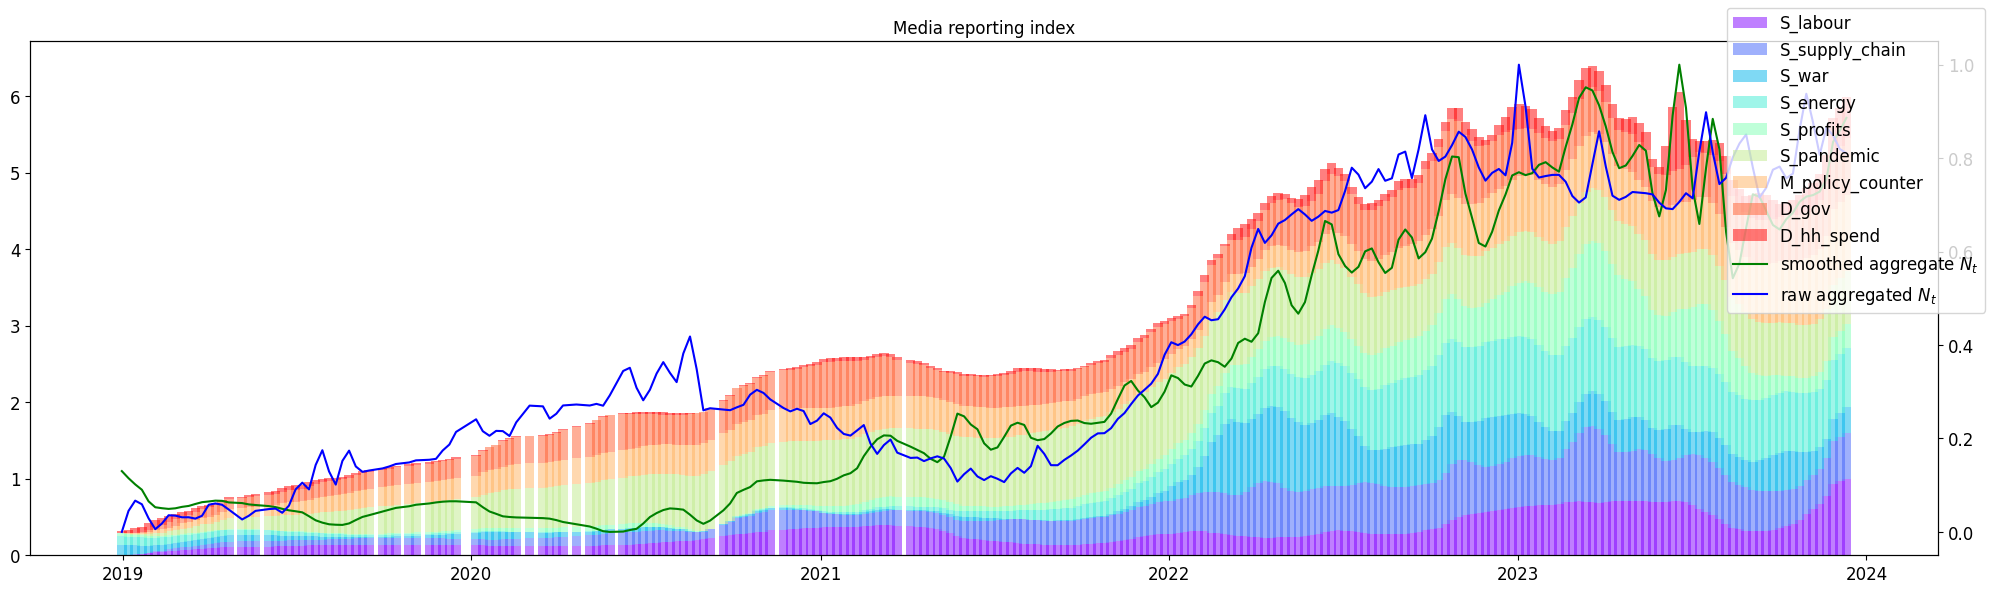

In [269]:
fig, ax = plt_stacked_bar(_.dropna(), bar_width=10)
ax2 = ax.twinx()
ax2.plot(tlda.T_sum_ind_op.dropna(), label='smoothed aggregate $N_t$', color='green')
ax2.plot(tlda.T_sum_raw.dropna(), label='raw aggregated $N_t$', color='blue')
fig.legend()

ax.set_title("Media reporting index", size=12)
fig.tight_layout()
save_fig(fig, 'topics_time.png')
;

### media and BEI

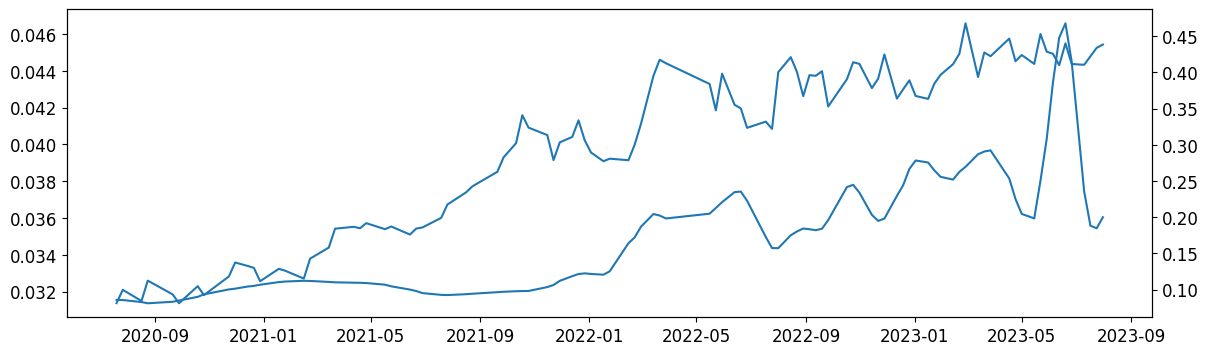

In [21]:
sub = df[['week_recorded', 'bei', 'T_sum']].groupby('week_recorded').last().dropna().copy()
fig, ax = get_fig_subplots()
ax.plot(sub.bei)
ax.twinx().plot(sub.T_sum)

### war and inflation as given by hh concern

In [270]:
sub = df[['week_recorded', 'percprob_war', 'percprob_covid']].copy().dropna()
sub = sub.groupby('week_recorded').mean()
sub = pd_join_freq(sub, tlda[['S_war', 'S_pandemic']].drop_duplicates() * 500, 'W', keep_left_index=False)
sub = sub.loc[~sub.index.duplicated()]

cols_endog, cols_exog = ['S_war'], ['percprob_war']
_dict = {'percprob_war': 'War perceived', 'percprob_covid': 'Covid-19 perceived', 'S_war': 'War report', 'S_pandemic': 'Covid-19 report'}

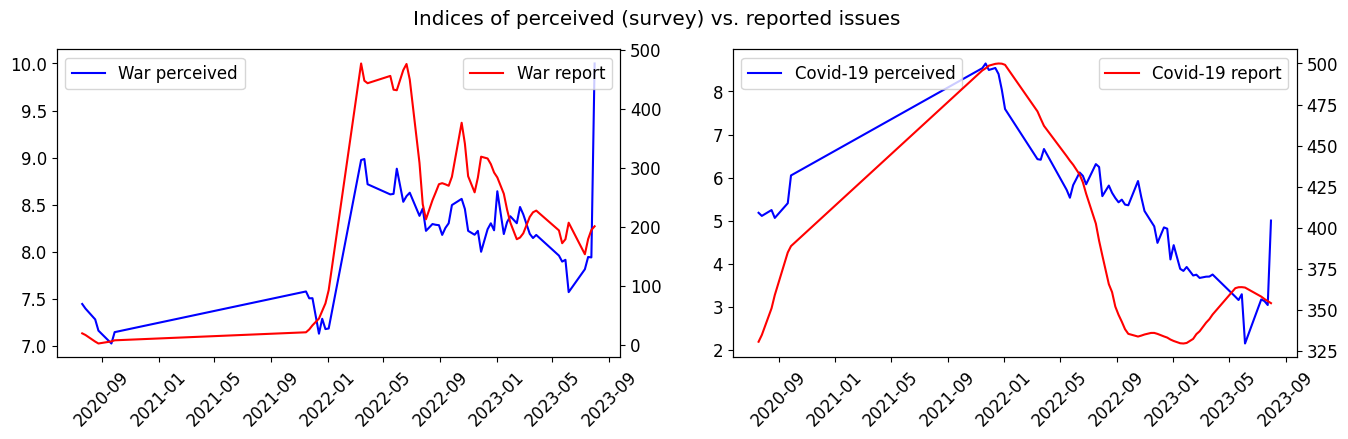

In [271]:
fig, axes = get_fig_subplots(2,2, figsize=(16,2))
lst_cols = [('percprob_war', 'S_war'), ('percprob_covid', 'S_pandemic')]
for idx, ax in enumerate(axes):
    ax.plot(sub[lst_cols[idx][0]], label=_dict[lst_cols[idx][0]], color='blue')
    ax2 = ax.twinx()
    ax2.plot(sub[lst_cols[idx][1]], label=_dict[lst_cols[idx][1]], color='red')
    ax2.legend(loc='upper right')
    ax.legend(loc='upper left')
    ax.tick_params(axis='x', rotation=45)
# axes[0].legend([
fig.suptitle("Indices of perceived (survey) vs. reported issues")
save_fig(fig, "topics_percprob.png")

In [301]:
out = sub.diff().dropna().corr().round(3)
_ = ["Perceived Ukraine conflict", "Perceived Covdi-19", "Media War", "Media Pandemic"]
out.columns = _
out.index = _
out

,Perceived Ukraine conflict,Perceived Covdi-19,Media War,Media Pandemic
Perceived Ukraine conflict,1.000,0.355,0.533,-0.035
Perceived Covdi-19,0.355,1.000,-0.213,0.575
Media War,0.533,-0.213,1.000,-0.132
Media Pandemic,-0.035,0.575,-0.132,1.000


In [303]:
save_pd_df(out, "tab_war_cov_corr.csv", GRAPHS_DIR)

## plot errors

In [21]:
dict_cols_pretty_names = {
    'delta_pe_MY_error_act': "$\~{\pi}^{\Delta e}_{t|t+12}$", 
    "pi_exp_MY_error_act": "$\~{\pi}^e_{t|t+12}$", 
    "pi_perc_MY_error_act": "$\~{\pi}^p_{t}$"
}

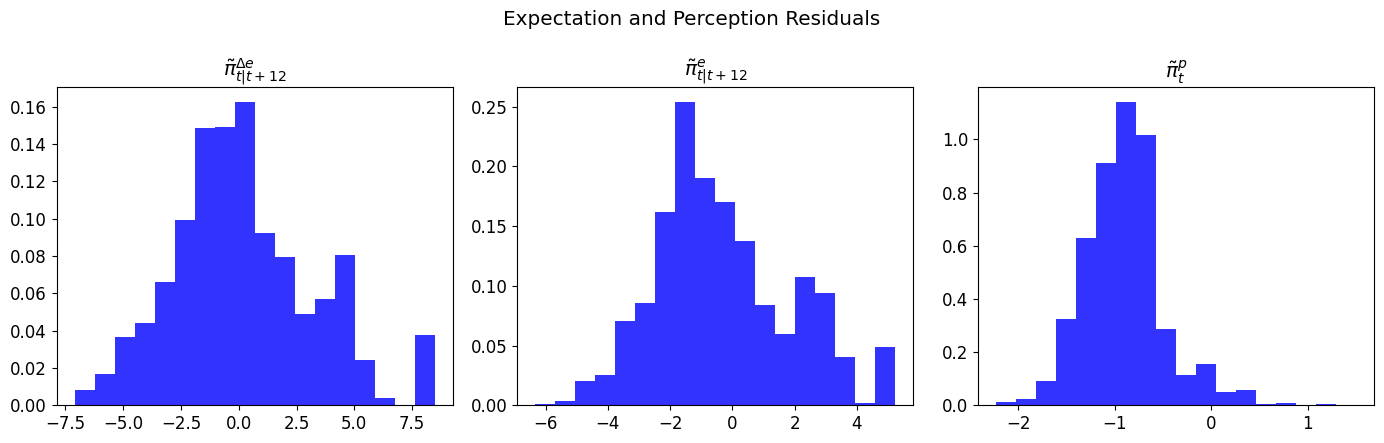

In [22]:
fig, axes = get_fig_subplots(3, 3, figsize=(14,1.5))
for i, ax in enumerate(axes):
    ax.set_title(list(dict_cols_pretty_names.keys())[i], size=10)
    ax.hist(df[['id', list(dict_cols_pretty_names.keys())[i]]].drop_duplicates().drop('id', axis=1).dropna(), 
            color='blue', alpha=.8, bins=18, density=True)
    ax.set_title(list(dict_cols_pretty_names.values())[i])
    
fig.suptitle("Expectation and Perception Residuals")
fig.tight_layout();
save_fig(fig, 'emp_error_hist.png')